In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import sampler
from torch.utils import data

In [2]:
data_dir = 'celeba/'

In [3]:
def get_dataloader(batch_size, image_size, data_dir=data_dir):
    transform=transforms.Compose([transforms.Resize((image_size,image_size)),transforms.ToTensor()])
    dataset=datasets.ImageFolder(root=data_dir, transform=transform)
    data_sampler=sampler.RandomSampler(dataset)
    data_loader=data.DataLoader(dataset=dataset,batch_size=batch_size,sampler=data_sampler)
    return data_loader

In [4]:
# Define function hyperparameters
batch_size = 20
img_size = 32
celeba_train_loader = get_dataloader(batch_size, img_size)

C:\Users\prese\AppData\Local\Temp/ipykernel_9672/2351865107.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])


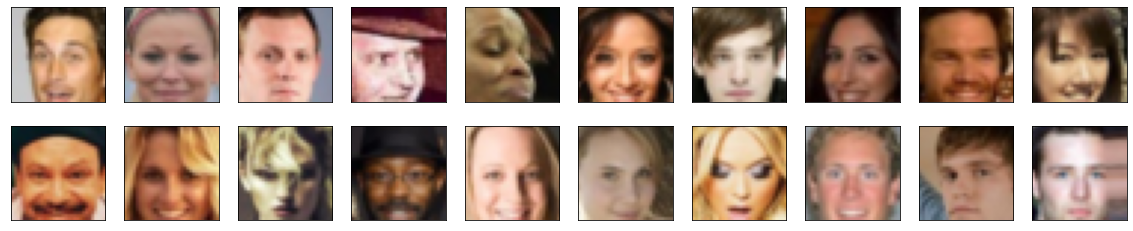

In [5]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() 
# _ for no labels

fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [6]:
def scale(x, feature_range=(-1, 1)):
    min,max=feature_range
    z=x*(max-min)+min
    return x

In [7]:
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(0.0196)
Max:  tensor(0.9961)


In [8]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):
    layers=[]
    conv_layer=nn.Conv2d(in_channels,out_channels,kernel_size,stride=2,padding=1)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [9]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()
        self.conv_dim=conv_dim
        self.conv1=conv(3,conv_dim*4,4,batch_norm=False)
        self.conv2=conv(conv_dim*4,conv_dim*8,4)
        self.conv3=conv(conv_dim*8,conv_dim*16,4)
        self.leakyrelu=nn.LeakyReLU(0.2)
        self.sigmoid=nn.Sigmoid()
        self.linear=nn.Linear(conv_dim*16*4*4,1)
        

    def forward(self, x):
        x=self.conv1(x)
        x=self.leakyrelu(self.conv2(x))
        x=self.leakyrelu(self.conv3(x))
        x=x.view(-1,self.conv_dim*16*4*4)
        x=self.linear(x)
        return x

In [10]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers=[]
    layers.append(nn.ConvTranspose2d(in_channels,out_channels,kernel_size=4,stride=2,padding=1,bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()

        self.conv_dim=conv_dim
        self.z_size=z_size
        self.fc=nn.Linear(z_size,conv_dim*4*4*16)
        self.deconv1=deconv(conv_dim*16,conv_dim*8)
        self.deconv2=deconv(conv_dim*8,conv_dim*4)
        self.deconv3=deconv(conv_dim*4,3,batch_norm=False)
        #self.conv=nn.Conv2d(conv_dim*4,3,kernel_size=3,padding=1)
        self.tanh=nn.Tanh()
        self.relu=nn.ReLU()

        

    def forward(self, x):
        x=self.fc(x)
        #print(x.size())
        x=x.view(-1,self.conv_dim*16,4,4)
        x=self.deconv1(x)
        x=self.relu(x)
        x=self.deconv2(x)
        x=self.relu(x)
        x=self.deconv3(x)
        x=self.tanh(x)        
        return x

In [11]:
from torch.nn import init
def weights_init_normal(m):
    classname = m.__class__.__name__
    init_gain=0.02
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, init_gain)
        
        if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
    
    elif classname.find('BatchNorm2d') != -1:  
        init.normal_(m.weight.data, 1.0, init_gain)
        init.constant_(m.bias.data, 0.0)

In [12]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [13]:
# Define model hyperparams
d_conv_dim = 10
g_conv_dim = 10
z_size = 30

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 40, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(40, 80, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(80, 160, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (leakyrelu): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
  (linear): Linear(in_features=2560, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=30, out_features=2560, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(160, 80, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(80, 40, kernel_size=(4, 4), 

In [14]:
import torch
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found.')
else:
    print('Training on GPU!')

No GPU found.


In [15]:
def real_loss(D_out,smooth=True):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) 
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)

    return loss

In [16]:
import torch.optim as optim

lr = 0.0002
beta1=0.5
beta2=0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [17]:
def train(D, G, n_epochs, print_every=50):
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    samples = []
    losses = []
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images=real_images.cuda()
            D_real=D(real_images)
            d_real_loss=real_loss(D_real)
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
        
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            g_optimizer.zero_grad()
        
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) 

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
          
            # Print some loss stats
            if batch_i % print_every == 0:
                losses.append((d_loss.item(), g_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses

In [18]:
# set number of epochs 
n_epochs = 10
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   10] | d_loss: 1.3944 | g_loss: 1.0565
Epoch [    1/   10] | d_loss: 0.5151 | g_loss: 2.7560
Epoch [    1/   10] | d_loss: 0.6433 | g_loss: 1.9583
Epoch [    1/   10] | d_loss: 0.6508 | g_loss: 1.7715
Epoch [    1/   10] | d_loss: 0.9983 | g_loss: 1.0678
Epoch [    1/   10] | d_loss: 0.9950 | g_loss: 0.9989
Epoch [    1/   10] | d_loss: 0.9232 | g_loss: 1.6765
Epoch [    1/   10] | d_loss: 1.1362 | g_loss: 1.2502
Epoch [    1/   10] | d_loss: 0.9493 | g_loss: 1.6269
Epoch [    1/   10] | d_loss: 1.3317 | g_loss: 0.7360
Epoch [    1/   10] | d_loss: 1.1006 | g_loss: 0.6071
Epoch [    1/   10] | d_loss: 0.8540 | g_loss: 1.3986
Epoch [    1/   10] | d_loss: 1.2807 | g_loss: 1.2233
Epoch [    1/   10] | d_loss: 1.0159 | g_loss: 1.6248
Epoch [    1/   10] | d_loss: 1.2609 | g_loss: 1.2796
Epoch [    1/   10] | d_loss: 1.0791 | g_loss: 0.8117
Epoch [    1/   10] | d_loss: 1.1753 | g_loss: 0.9900
Epoch [    1/   10] | d_loss: 1.2532 | g_loss: 0.9730
Epoch [    1/   10] | d_loss

Epoch [    3/   10] | d_loss: 0.9914 | g_loss: 1.6614
Epoch [    3/   10] | d_loss: 1.1427 | g_loss: 1.1097
Epoch [    3/   10] | d_loss: 1.0650 | g_loss: 0.9259
Epoch [    3/   10] | d_loss: 1.1893 | g_loss: 1.0044
Epoch [    3/   10] | d_loss: 1.1092 | g_loss: 1.0449
Epoch [    3/   10] | d_loss: 1.2077 | g_loss: 0.9232
Epoch [    3/   10] | d_loss: 1.0651 | g_loss: 1.5553
Epoch [    3/   10] | d_loss: 1.0122 | g_loss: 1.2973
Epoch [    3/   10] | d_loss: 1.0564 | g_loss: 1.2451
Epoch [    3/   10] | d_loss: 0.8633 | g_loss: 1.4759
Epoch [    3/   10] | d_loss: 1.1157 | g_loss: 1.4520
Epoch [    3/   10] | d_loss: 1.3314 | g_loss: 1.1228
Epoch [    3/   10] | d_loss: 1.2007 | g_loss: 1.2595
Epoch [    3/   10] | d_loss: 1.1168 | g_loss: 1.0636
Epoch [    3/   10] | d_loss: 1.0605 | g_loss: 1.4862
Epoch [    3/   10] | d_loss: 1.1990 | g_loss: 1.2815
Epoch [    3/   10] | d_loss: 1.1629 | g_loss: 1.0669
Epoch [    3/   10] | d_loss: 1.1673 | g_loss: 0.7166
Epoch [    3/   10] | d_loss

Epoch [    6/   10] | d_loss: 1.0794 | g_loss: 1.2978
Epoch [    6/   10] | d_loss: 0.8800 | g_loss: 2.0617
Epoch [    6/   10] | d_loss: 1.5719 | g_loss: 1.1203
Epoch [    6/   10] | d_loss: 1.0282 | g_loss: 1.3411
Epoch [    6/   10] | d_loss: 0.9165 | g_loss: 1.8987
Epoch [    6/   10] | d_loss: 0.9748 | g_loss: 2.3665
Epoch [    6/   10] | d_loss: 0.8751 | g_loss: 1.8324
Epoch [    6/   10] | d_loss: 0.9655 | g_loss: 1.6104
Epoch [    6/   10] | d_loss: 0.8035 | g_loss: 2.0872
Epoch [    6/   10] | d_loss: 1.0083 | g_loss: 1.0231
Epoch [    6/   10] | d_loss: 1.2806 | g_loss: 1.6211
Epoch [    6/   10] | d_loss: 0.7925 | g_loss: 1.9716
Epoch [    6/   10] | d_loss: 0.8196 | g_loss: 1.3376
Epoch [    6/   10] | d_loss: 0.8385 | g_loss: 1.8481
Epoch [    6/   10] | d_loss: 0.9463 | g_loss: 1.2814
Epoch [    6/   10] | d_loss: 0.9755 | g_loss: 1.9410
Epoch [    6/   10] | d_loss: 1.1383 | g_loss: 1.5972
Epoch [    6/   10] | d_loss: 1.1180 | g_loss: 1.4232
Epoch [    6/   10] | d_loss

Epoch [    8/   10] | d_loss: 0.9035 | g_loss: 1.6523
Epoch [    8/   10] | d_loss: 0.8976 | g_loss: 1.8533
Epoch [    8/   10] | d_loss: 0.6528 | g_loss: 1.9734
Epoch [    8/   10] | d_loss: 1.1666 | g_loss: 1.3270
Epoch [    8/   10] | d_loss: 0.7302 | g_loss: 1.5863
Epoch [    8/   10] | d_loss: 0.7730 | g_loss: 1.7828
Epoch [    8/   10] | d_loss: 0.6480 | g_loss: 1.9885
Epoch [    8/   10] | d_loss: 0.8713 | g_loss: 1.6607
Epoch [    9/   10] | d_loss: 1.6160 | g_loss: 2.8394
Epoch [    9/   10] | d_loss: 0.8404 | g_loss: 1.7736
Epoch [    9/   10] | d_loss: 0.9905 | g_loss: 1.7838
Epoch [    9/   10] | d_loss: 0.6260 | g_loss: 2.5529
Epoch [    9/   10] | d_loss: 0.9275 | g_loss: 1.9505
Epoch [    9/   10] | d_loss: 0.7247 | g_loss: 1.6050
Epoch [    9/   10] | d_loss: 0.6795 | g_loss: 2.2972
Epoch [    9/   10] | d_loss: 0.5847 | g_loss: 2.0517
Epoch [    9/   10] | d_loss: 0.6379 | g_loss: 2.0048
Epoch [    9/   10] | d_loss: 1.2037 | g_loss: 0.8546
Epoch [    9/   10] | d_loss

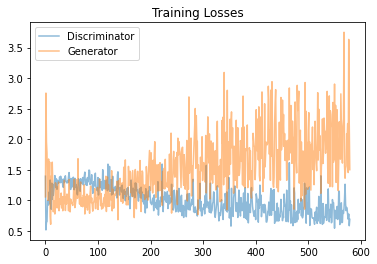

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [24]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [25]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

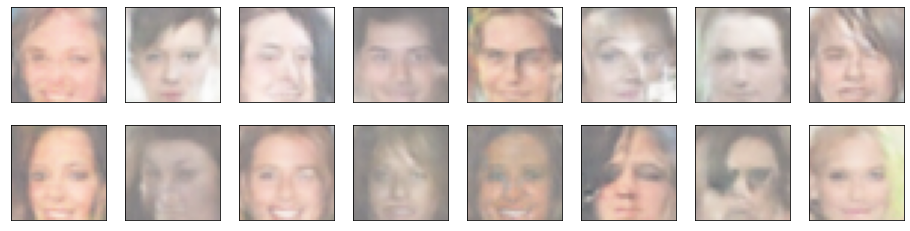

In [26]:
_ = view_samples(-1, samples)

-------------------------------------------------------------------